In [2]:
# Importing modules

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the data

paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [4]:
len(paths)

2800

In [5]:
paths[:5]

['/kaggle/input/speech-emotion/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/speech-emotion/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/speech-emotion/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/speech-emotion/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/speech-emotion/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [6]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [7]:
# Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/kaggle/input/speech-emotion/TESS Toronto emot...,fear
1,/kaggle/input/speech-emotion/TESS Toronto emot...,fear
2,/kaggle/input/speech-emotion/TESS Toronto emot...,fear
3,/kaggle/input/speech-emotion/TESS Toronto emot...,fear
4,/kaggle/input/speech-emotion/TESS Toronto emot...,fear


In [8]:
df['label'].value_counts()

fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: label, dtype: int64

In [10]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveplot(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [18]:
# Feature extraction

def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [19]:
extract_mfcc(df['speech'][0])

array([-285.73727   ,   85.78295   ,   -2.1689112 ,   22.125532  ,
        -14.757395  ,   11.051346  ,   12.412449  ,   -3.0002618 ,
          1.0844991 ,   11.078272  ,  -17.41966   ,   -8.093213  ,
          6.5879726 ,   -4.2209535 ,   -9.15508   ,    3.52148   ,
        -13.186381  ,   14.078853  ,   19.66973   ,   22.725618  ,
         32.57464   ,   16.325035  ,   -3.8427293 ,    0.89629656,
        -11.239262  ,    6.653462  ,   -2.5883696 ,   -7.7140164 ,
        -10.941658  ,   -2.4007547 ,   -5.281288  ,    4.271157  ,
        -11.202216  ,   -9.024621  ,   -3.6669848 ,    4.869744  ,
         -1.6027985 ,    2.5600514 ,   11.454374  ,   11.233449  ],
      dtype=float32)

In [20]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [21]:
X_mfcc

0       [-285.73727, 85.78295, -2.1689112, 22.125532, ...
1       [-348.34332, 35.193233, -3.841328, 14.658875, ...
2       [-340.11435, 53.796444, -14.267782, 20.884027,...
3       [-306.63422, 21.259708, -4.4110823, 6.4871554,...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
2795    [-374.3952, 60.864998, 0.025059083, 8.431058, ...
2796    [-313.96478, 39.847843, -5.6493053, -3.867575,...
2797    [-357.54886, 77.886055, -15.224756, 2.194633, ...
2798    [-353.1474, 101.68391, -14.175896, -12.037376,...
2799    [-389.4595, 54.042767, 1.346998, -1.4258983, -...
Name: speech, Length: 2800, dtype: object

In [22]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [24]:
# input split
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1, 1)

In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [26]:
y = y.toarray()

In [27]:
y.shape

(2800, 7)

In [28]:
# Create the LSTM model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [29]:
# Train the model
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
35/35 [==============================] - 7s 127ms/step - loss: 1.1517 - accuracy: 0.5799 - val_loss: 2.5312 - val_accuracy: 0.0071
Epoch 2/50
35/35 [==============================] - 4s 111ms/step - loss: 0.4257 - accuracy: 0.8540 - val_loss: 2.5310 - val_accuracy: 0.3000
Epoch 3/50
35/35 [==============================] - 4s 109ms/step - loss: 0.1825 - accuracy: 0.9424 - val_loss: 2.1704 - val_accuracy: 0.3964
Epoch 4/50
35/35 [==============================] - 4s 118ms/step - loss: 0.1857 - accuracy: 0.9451 - val_loss: 2.4147 - val_accuracy: 0.3446
Epoch 5/50
35/35 [==============================] - 4s 113ms/step - loss: 0.1348 - accuracy: 0.9594 - val_loss: 2.3981 - val_accuracy: 0.4339
Epoch 6/50
35/35 [==============================] - 4s 111ms/step - loss: 0.0993 - accuracy: 0.9692 - val_loss: 2.4520 - val_accuracy: 0.4464
Epoch 7/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0689 - accuracy: 0.9790 - val_loss: 3.4151 - val_accuracy: 0.3411
Epoch 

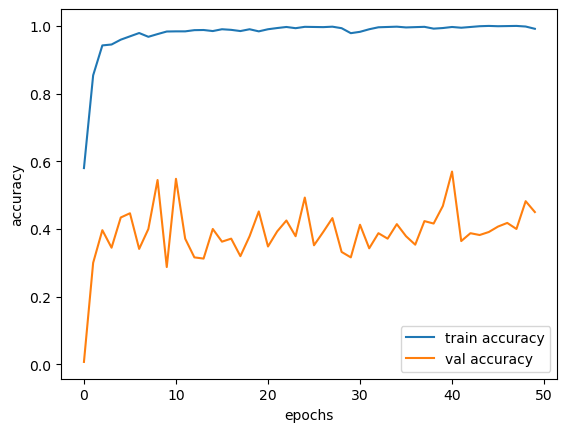

In [30]:
# Plot the results

epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

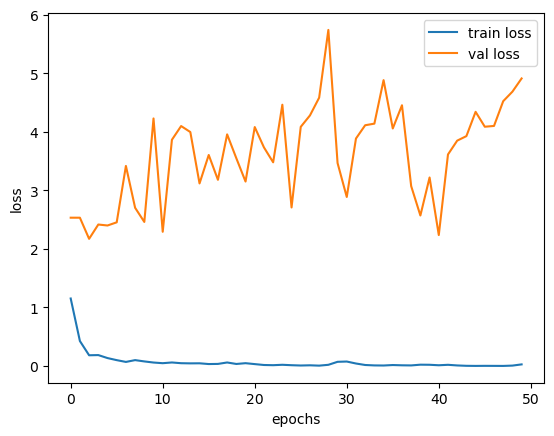

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()